# Input.csv contains 

- Age 

- Sex

- Care Home Flag

- MSOA

- STP

- IMD

- HighRisk Condition Flags

- etc.

## Packages

In [198]:
import pandas as pd
import numpy as np
import pyspark.sql
import matplotlib.pyplot as plt

## Data

Currently Risk factors are set to first date.  When no date recorded value is NaN.  Replace all NaNs with 0.  Exception is BMI: replace NaN with -99 to indicate poor data

In [207]:
df = pd.read_csv("../output/input.csv")
df.iloc[:,1:11] = df.iloc[:,1:11].where(df.iloc[:,1:11].isnull(), 1).fillna(0).astype(int)
df.loc[:,'bmi'] = df.loc[:,'bmi'].fillna(-99)
df.head()

,patient_id,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,haematological_cancer,permanant_immunosuppression,temporary_immunosuppression,solid_organ_transplantation,stroke,age,sex,bmi,stp,msoa,imd,rural_urban
0,0,0,0,0,0,1,0,0,0,0,0,76,M,-99.000000,STP1,MSOA1,100,urban
1,1,0,0,0,0,0,0,0,0,0,0,32,M,34.475170,STP1,MSOA1,300,urban
2,2,0,1,1,0,0,1,0,0,0,0,15,M,33.366594,STP2,MSOA2,300,urban
3,3,1,0,0,0,1,0,0,0,1,1,70,M,-99.000000,STP1,MSOA2,300,urban
4,4,0,1,0,0,0,0,0,0,0,0,74,F,34.133095,STP1,MSOA2,200,urban


## Quick Summary stats

In [208]:
df.describe()

,patient_id,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,haematological_cancer,permanant_immunosuppression,temporary_immunosuppression,solid_organ_transplantation,stroke,age,bmi,imd
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,40.270200,-18.478193,259.540000
std,2886.89568,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,23.767858,66.199084,66.913647
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,-99.000000,100.000000
25%,2499.75000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,21.000000,-99.000000,200.000000
50%,4999.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,40.000000,25.571605,300.000000
75%,7499.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,59.000000,37.432511,300.000000
max,9999.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,108.000000,72.590580,300.000000


## Feature Generation

Set High and Medium Risk Flags based on conditions.  

Set priority flag based on eligibility criteria

In [215]:
df['num_conditions'] = df.iloc[:,1:11].sum(axis=1)
df['risk'] = 0
conditions = [
    (df['num_conditions']>0) & (df['num_conditions']<3),
    (df['num_conditions']>=3)
]
values = ['medium','high']
df['risk'] = np.select(conditions, values)

In [213]:
df['priority'] = 0
conditions = [
    (df['age'] >= 80) & (df['risk'] == 'high'),
    (df['age'] >= 80),
    (df['age'] >= 75),
    (df['age'] >= 70),
    (df['age'] >= 65),
    (df['age'] < 65) & (df['risk'] == 'high'),
    (df['age'] < 65) & (df['risk'] == 'medium'),
    (df['age'] >= 60) & (df['risk'] == '0'),
    (df['age'] >= 55) & (df['risk'] == '0'),
    (df['age'] >= 50) & (df['risk'] == '0'),
    (df['age'] < 50)
]
values = [1,2,3,4,5,6,7,8,9,10,11]
df['priority'] = np.select(conditions, values)
df.head()


,patient_id,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,haematological_cancer,permanant_immunosuppression,temporary_immunosuppression,solid_organ_transplantation,...,age,sex,bmi,stp,msoa,imd,rural_urban,num_conditions,risk,priority
0,0,0,0,0,0,1,0,0,0,0,...,76,M,-99.000000,STP1,MSOA1,100,urban,1,medium,3
1,1,0,0,0,0,0,0,0,0,0,...,32,M,34.475170,STP1,MSOA1,300,urban,0,0,11
2,2,0,1,1,0,0,1,0,0,0,...,15,M,33.366594,STP2,MSOA2,300,urban,3,high,6
3,3,1,0,0,0,1,0,0,0,1,...,70,M,-99.000000,STP1,MSOA2,300,urban,4,high,4
4,4,0,1,0,0,0,0,0,0,0,...,74,F,34.133095,STP1,MSOA2,200,urban,1,medium,4


In [220]:
freq = df['priority'].value_counts().sort_index()
display(freq)

1      282
2      194
3      322
4      548
5      514
6     5122
7     2171
8       51
9       60
10      68
11     668
Name: priority, dtype: int64

## Waterfall chart

In [237]:
csum=freq.cumsum().shift(1).fillna(0)
#step = csum.reset_index(drop=True).repeat(3).shift(1)
#step[1::3] = np.nan
display(csum)
#display(step)

1        0.0
2      282.0
3      476.0
4      798.0
5     1346.0
6     1860.0
7     6982.0
8     9153.0
9     9204.0
10    9264.0
11    9332.0
Name: priority, dtype: float64

[Text(0, 0, 'Older Residents & care workers in Care Homes'),
 Text(1, 0, '80+ & Health and care Workers'),
 Text(2, 0, '75+'),
 Text(3, 0, '70+'),
 Text(4, 0, '65+'),
 Text(5, 0, 'High Risk under 65'),
 Text(6, 0, 'Medium Risk under 65'),
 Text(7, 0, '60+'),
 Text(8, 0, '55+'),
 Text(9, 0, '50+'),
 Text(10, 0, 'Rest')]

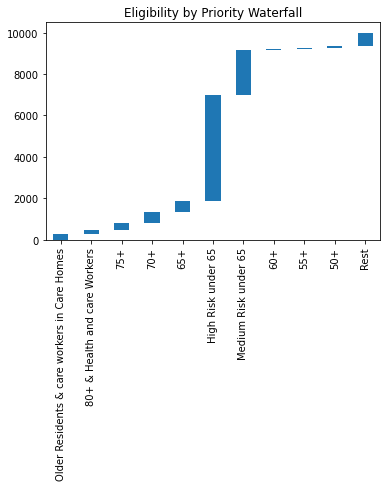

In [238]:
labels = ['Older Residents & care workers in Care Homes', '80+ & Health and care Workers', '75+', '70+', '65+', 'High Risk under 65', 'Medium Risk under 65', '60+', '55+', '50+', 'Rest']
my_plot = freq.plot(kind='bar', stacked=True, bottom=csum,legend=None, title="Eligibility by Priority Waterfall")
my_plot.set_xticklabels(labels)
#my_plot.plot(step.index, step.values,'k')